# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

608

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Config Information
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

In [4]:
# Decalre list values 
cities_list = []
lat = []
lon = []
temp = []
humidity = []
clouds = []
wind = []
country = []
date = []
# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="
# Print statement
print('*'*20)
print('Data Processing')
print('*'*20)
# Counter Variable
i = 1
# Loop
for city in cities:
    try: 
        response = requests.get(query_url + city).json()
        # Pull data into list
        cities_list.append(response['name'])
        lat.append(response['coord']['lat'])
        lon.append(response['coord']['lon'])
        temp.append(response['main']['temp_max'])
        humidity.append(response['main']['humidity'])
        clouds.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        country.append(response['sys']['country'])
        date.append(response['dt'])
        print(f'Processing record {i} | {city}')
        i +=1
    except KeyError:
        print(f'City {i} not found. Skipping...')
print('*'*20)
print('Done')
print('*'*20)

********************
Data Processing
********************
Processing record 1 | shahr-e babak
Processing record 2 | comodoro rivadavia
Processing record 3 | punta arenas
Processing record 4 | kaitangata
Processing record 5 | vaini
Processing record 6 | hervey bay
Processing record 7 | kathu
Processing record 8 | san lorenzo
Processing record 9 | casablanca
Processing record 10 | ushuaia
Processing record 11 | saint-georges
Processing record 12 | rikitea
Processing record 13 | qaanaaq
Processing record 14 | kodinar
Processing record 15 | ankpa
Processing record 16 | tiksi
Processing record 17 | bengkulu
Processing record 18 | labuhan
Processing record 19 | villerupt
Processing record 20 | cape town
Processing record 21 | gilgit
Processing record 22 | fort-shevchenko
Processing record 23 | klaksvik
Processing record 24 | codrington
Processing record 25 | faya
Processing record 26 | kutum
Processing record 27 | ardakan
Processing record 28 | albany
Processing record 29 | port elizabeth
Pr

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Create Data Dictonary
weather_data = {
    'City': cities_list,
    'Latitude': lat,
    'Longitude': lon,
    'Max Temperature': temp, 
    'Humidity': humidity,
    'Cloudiness': clouds,
    'Wind Speed': wind,
    'Country': country,
    'Date': pd.to_datetime(date, unit="s")
}
weather_df = pd.DataFrame(weather_data)
# Exporting the data to a CSV file.
weather_df.to_csv(output_data_file)
# View head to check data
weather_df.head()

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date
0,Shahr-e Bābak,30.1165,55.1186,74.71,19,15,5.26,IR,2021-09-19 19:56:38
1,Comodoro Rivadavia,-45.8667,-67.5000,52.86,55,7,4.27,AR,2021-09-19 20:00:01
2,Punta Arenas,-53.1500,-70.9167,50.11,57,75,31.07,CL,2021-09-19 19:51:22
3,Kaitangata,-46.2817,169.8464,41.32,92,46,5.84,NZ,2021-09-19 19:54:29
4,Vaini,-21.2000,-175.2000,71.76,88,40,9.22,TO,2021-09-19 19:51:49


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [10]:
#  Get the indices of cities that have humidity over 100%.
print(weather_df[weather_df['Humidity']>100].index.values)
weather_df.describe()

[]


,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,19.887275,21.735920,65.970775,70.664865,53.497297,8.032252
std,33.154921,88.971901,17.298470,21.184579,40.138181,5.249053
min,-54.800000,-179.166700,17.150000,9.000000,0.000000,0.000000
25%,-6.932750,-55.501400,53.805000,62.500000,9.000000,3.990000
50%,22.678300,23.450000,69.750000,75.000000,58.000000,7.070000
75%,47.836100,102.203150,78.600000,86.500000,97.000000,10.625000
max,78.218600,178.416700,104.970000,100.000000,100.000000,31.070000


In [9]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".

,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,19.887275,21.735920,65.970775,70.664865,53.497297,8.032252
std,33.154921,88.971901,17.298470,21.184579,40.138181,5.249053
min,-54.800000,-179.166700,17.150000,9.000000,0.000000,0.000000
25%,-6.932750,-55.501400,53.805000,62.500000,9.000000,3.990000
50%,22.678300,23.450000,69.750000,75.000000,58.000000,7.070000
75%,47.836100,102.203150,78.600000,86.500000,97.000000,10.625000
max,78.218600,178.416700,104.970000,100.000000,100.000000,31.070000


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

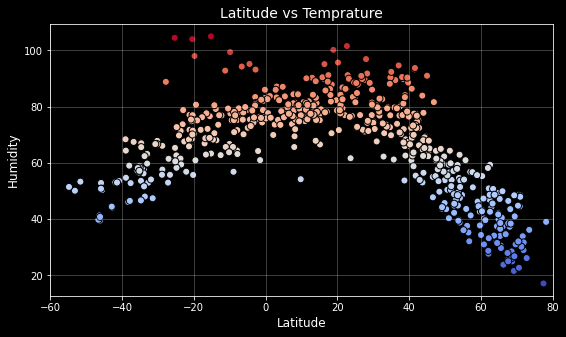

In [42]:
# Set up vars
lat = weather_df['Latitude']
temp = weather_df['Max Temperature']
# Figure size
plt.figure(figsize=(9,5))
# Plot 
plt.scatter(lat, temp, cmap='coolwarm', c = temp, edgecolor= 'black', marker='o', s=50)
# Label Plot
plt.title('Latitude vs Temprature', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Temprature', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Latitude vs. Humidity Plot

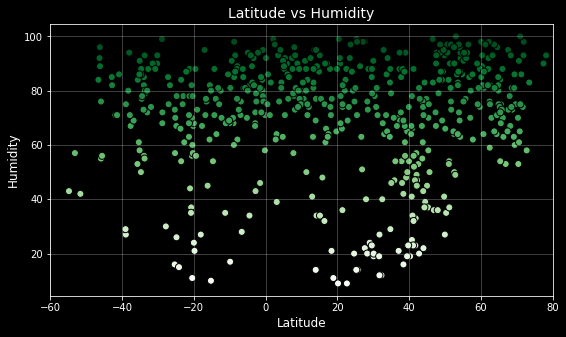

In [52]:
# Set up vars
lat = weather_df['Latitude']
humidity = weather_df['Humidity']
# Figure size
plt.figure(figsize=(9,5))
# Plot
plt.scatter(lat, humidity, c=humidity, cmap='Greens', edgecolor='black', s=50)
# Label
plt.title('Latitude vs Humidity', fontsize=14)
plt.xlabel('Latitude', fontsize=12)
plt.ylabel('Humidity', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()


## Latitude vs. Cloudiness Plot

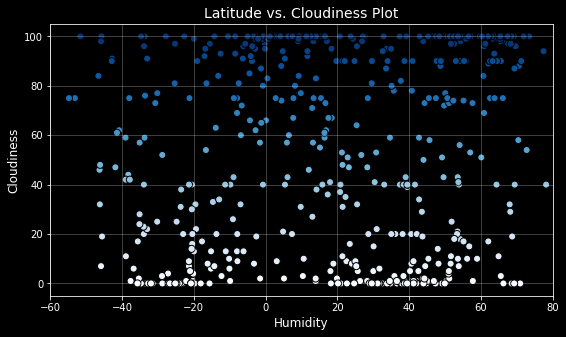

In [44]:
# Set up vars
lat = weather_df['Latitude']
cloud = weather_df['Cloudiness']
# Figure size
plt.figure(figsize=(9,5))
# Plot
plt.scatter(lat, cloud, c=cloud, edgecolors='black', cmap='Blues', s =50)
# Label
plt.title('Latitude vs. Cloudiness Plot', fontsize=14)
plt.xlabel('Humidity', fontsize=12)
plt.ylabel('Cloudiness', fontsize=12)
# Grid fade and xlim for visualization
plt.grid(alpha=0.3)
plt.xlim(-60, 80)
# Show plot
plt.show()

## Latitude vs. Wind Speed Plot

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression